手写数字识别器（练习）
------
在追逐梦想的道路上勇往直行

In [21]:
# 引入该CNN所需的包
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 以下语句可以让JupyterNotebook直接输出图像
%matplotlib inline

In [2]:
# 定义一些训练用的超参数
# 图像的总尺寸28x28
image_size = 28
# 标签的种类数
num_classes = 10
# 训练的总循环周期
num_epochs = 20
# 一个批次的大小，64张图片
batch_size = 64

In [3]:
# 加载MNIST数据，如果没有下载过，系统就会在当前路径下新建/data子目录，并把文件存放在其中（压缩的格式）
# MNSIT数据属于torchvision包自带的数据，可以直接调用
# 但用户想要调用自己的图像数据时，可以用torchvision.datasets.ImageFloder
# 或torch.utlis.data.TensorDataset来加载
train_dataset = dsets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
                          # 文件存放路径，提取训练集，将图像转换为Tensor，在加载图像时就可以对其做预处理，找不到文件的时候就可以自动下载
# 加载测试数据
test_dataset = dsets.MNIST(root='./data',train=False,transform=transforms.ToTensor())
# 训练数据集的加载器，自动将数据切成分批，顺序随机打乱
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

'''我们希望将测试数据分成两部分，一部分作为校验数据，一部分作为测试数据
校验数据用于检测模型是否过拟合并调整参数，测试数据检验整个模型的工作'''

# 首先，定义下标数组indices，它相当于对所有test_dataset中数据的编码
# 然后，定义下标indices_val 表示校验集数据的下标，indices_test 表示测试数据集的下标
indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

# 根据下标构造的两个数据集的SubsetRandomSampler 采样器，它会对下标进行采样
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

# 根据两个采样器定义加载器
# 注意将sampler_val 和 sampler_test 分别赋值给了validation_loader 和 test_loader
validation_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,sampler=sampler_val)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,sampler=sampler_test)

标签是： 5


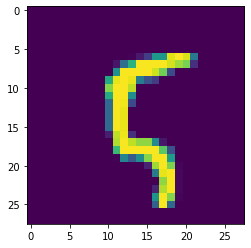

In [18]:
# 随便从数据集中读入一张图片，并绘制出来
idx = 100
# dataset 支持下标索引，其中提取出来的元素为features,target格式，即属性和标签 【0】表示索引features
muteimg = train_dataset[idx][0].numpy()
# print(muteimg.size)
# print(muteimg[0].size)
# print(muteimg[0].shape)
# print(muteimg.shape)
# print(type(muteimg))
# print(muteimg[0])
# 一般的图像包含RGB这三个通道，而MNIST数据集的图像都是灰度的，只有一个通道
# 因此，我们忽略通道，把图像看作为一个灰度矩阵
# 用 imshow 画图，会将灰度矩阵自动展现为彩色，不同灰度对应不同的颜色，从黄到紫

plt.imshow(muteimg[0])
print('标签是：',train_dataset[idx][1])

In [48]:
# 定义卷积神经网络，4和8为人为指定的两个卷积层的厚度（features map 的数量）
depth = [4,8]
class ConvNet(nn.Module):
    def __init__(self):
        # 该函数在创建一个ConvNet对象即调用语句net=ConvNet（）时就会被调用
        # 首先调用父类相应的构造函数
        super(ConvNet,self).__init__()
        
        # 其次构造ConvNet需要用到的各个神经模块
        # 注意，定义组件并不是真正的搭建组件，只是把基本建筑砖块先找好
        # 定义一个卷积层，输入通道为1，输出通道为4，窗口大小为5，padding为2
        self.conv1 = nn.Conv2d(1,4,5,padding=2)
        # 定义一个池化层，一个窗口为2X2的池化运算
        self.pool = nn.MaxPool2d(2,2)
        
        # 第二层卷积，输入通道为depth[0],输出通道为depth[1]，窗口大小为5，padding为2
        self.conv2 = nn.Conv2d(depth[0],depth[1],5,padding=2)
        
        # 一个线性连接层，输入尺寸为最后一层立方体的线性平铺，输出层512个节点
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1],512)
        # 最后一层的线性分类单元，输入为512，输出为要做分类的类别数
        self.fc2 = nn.Linear(512,num_classes)
        
    # 该函数完成神经网络真正的前向运算，在这里把各个组件进行实际拼装
    def forward(self,x):
        # x 的尺寸：(batch_size,image_channels,image_width,image_height)
        x = self.conv1(x) # 第一层卷积
        x = F.relu(x)     # 激活函数用ReLU，防止过拟合
        # x 的尺寸：(batch_size,num_filters,image_width,image_height)
        
        x = self.pool(x)  # 第二层池化,将图片变小
        # x 的尺寸：(batch_size,depth[0],image_width/2,image_height/2)
        
        x = self.conv2(x) # 第三层又是卷积，窗口为5，输入输出通道分为别是depth[0]=4,depth[1]=8
        x = F.relu(x)     # 非线性函数
        # x 的尺寸:(batch_size,depth[1],image_width/2,image_height/2)
        
        x = self.pool(x)  # 第四层池化，将图片缩小为原来的1/4
        # x 的尺寸:(batch_size,depth[1],image_width/4,image_height/4)
        
        # 将立体图的特征图tensor压缩成一个一维的向量
        # view函数可以将一个tensor按指定的方式重新排部
        # 下面这个命令就是要让x按照batch_size * (image_size//4)^2*depth[1] 的方式来排部向量
        x = x.view(-1,image_size//4*image_size//4*depth[1])
        # x 的尺寸:(batch_size,depth[1]*image_size/4*image_size/4)
        
        x = F.relu(self.fc1(x)) # 第五层为全连接，ReLU激活函数
        # x 的尺寸:(batch_size,512)
        
        # 以默认的0.5的概率对这一层进行dropout操作，防止过拟合
        x = F.dropout(x,training=self.training)
        x = self.fc2(x) # 全连接
        # x 的尺寸:(batch_size,num_classes)
        
        # 输出层为log_softmax,即 概率 对数值log(p(x))。采用log_softmax 可以使后面的交叉熵计算更快
        x = F.log_softmax(x,dim=1)
        return x
    
    def retrieve_features(self,x):
        # 该函数用于提取卷积神经网络的特征图，返回feature_map1,feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x)) # 完成第一层卷积
        x = self.pool(feature_map1) # 完成第一次池化
        # 第二次卷积，两层的特征图都储存到了feature_map1,feature_map2中
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1,feature_map2)

In [51]:
def rightness(predictions,labels):
    '''计算预测错误率的函数，其中prediction是模型给出的一组预测结果，
       batch_size行num_classes列的矩阵，labels是数据之中的正确的答案'''
    pred = torch.max(predictions.data,1)[1]
    # 对于任意一行（一个样本）的输出值的第一个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum()
    # 将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights,len(labels)
    # 返回正确的数量和这一次一共比较了多少元素

In [52]:
# 新建一个卷积神经网络的实例，此时ConvNet 的 __init__()函数会被自动调用
net = ConvNet()

# Loss 函数的定义，交叉熵
criterion = nn.CrossEntropyLoss()

# 定义优化器，普通的随机梯度下降法
# optimizer = optim.SGD(net.parameters(),lr=1e-3,momentum=0.9)
optimizer = optim.Adam(net.parameters(),lr=1e-3)

# 记录准确率等数值的容器
record = []

# 每若干步就记一次卷积核
weights = []

# 开始训练循环
for epoch in range(num_epochs):
    # 记录训练数据集准确率的容器
    train_rights = []
    ''' 下面的enumerate 起到构造一个枚举器的作用。
        在对train_loader 做循环迭代时，enumerate会自动输出一个数字指示循环了几次，
        并记录在batch_idx中，它就等于0，1，2，3，...train_loader 没迭代一次，
        就会输出一对数据data和target，分别对应一个批中的手写数字图及对应的标签'''
    
    # 针对容器中每一个批进行循环
    for batch_idx,(data,target) in enumerate(train_loader):
        # 将 Tensor 转化为 Variable ，data为一批图像，target为一批标签
        data,target = Variable(data),Variable(target)
        # 给网络模型做标记，标志着模型在训练集上训练
        # 这种区分主要是为了打开关闭net的training标志，从而决定是否运行dropout
        net.train()
        
        # 神经网络完成一次前馈计算过程，得到预测输出output
        output = net(data)
        # 将output与标签target比较，计算误差
        loss = criterion(output,target)
        # 清空梯度
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 一步随机梯度下降算法
        optimizer.step()
        
        # 计算准确率所需数值，返回数值为（正确样例数，总样本数）
        right = rightness(output,target)
        # 将计算结果装到列表容器train_rights中
        train_rights.append(right)
        
        # 每隔100个batch_size执行一次打印
        if batch_idx % 100 == 0:
            # 给网络模型做标记，标志着模型在训练集上训练
            net.eval()
            # 记录校验数据集准确率的容器
            val_rights = []
            
            # 在开始校验集上做循环，计算校验集上的准确率
            for (data,target) in validation_loader:
                data,target = Variable(data),Variable(target)
                # 完成一次前馈计算过程，得到目前训练得到的模型net在校验集上的表现，
                output = net(data)
                # 计算准确率所需的数值，返回正确的数值为（正确样例数，总样本数）
                right = rightness(output,target)
                val_rights.append(right)
            
            # 分别计算目前已经计算过的训练集以及全部校验集上的模型表现：分类准确率
            # train_r 为一个二元组，分别记录经历过的所有训练集中分类正确的数量和该集合中的总样本数
            # train_r[0]/train_r[1] 是训练集的分类准确度，val_r[0]/val_r[1]是校验集的分类准确度
            train_r = (sum([tup[0] for tup in train_rights]),sum([tup[1] for tup in train_rights]))
            # val_r 为一个二元组，分别记录校验集中分类正确的数量和该集合中总的样本数
            val_r = (sum([tup[0] for tup in val_rights]),sum([tup[1] for tup in val_rights]))
            
            # 打印准确率等数值，其中正确率为本训练周期epoch开始后到目前批的正确率的平均值
            print('训练周期:{}[{}/{}({:.0f}%)]\t,Loss:{:.6f}\t,训练正确率:{:.2f}%\t,\
                  校验正确率:{:.2f}%'.format(
                        epoch,batch_idx*len(data),len(train_loader.dataset),
                        100.*batch_idx/len(train_loader),loss.data,
                        100.*train_r[0].numpy()/train_r[1],
                        100.*val_r[0].numpy()/val_r[1]))
            # 将准确率和权重等数值加载到容器中，方便后续的处理
            record.append((100 - 100. * train_r[0] / train_r[1],100 - 100. * val_r[0] / val_r[1]))
            
            # weights 记录了训练周期中所有卷积核的演化过程，net.conv1.weight 提取出了第一层卷积核的权重
            # clone 是将weight.data 中的数据做一个备份放到列表中
            # 否则当weight.data 变化时，列表中的每一项数值也会联动
            # 这里使用clone 这个函数很重要
            weights.append([net.conv1.weight.data.clone(),net.conv1.bias.data.clone(),
                           net.conv2.weight.data.clone(),net.conv2.bias.data.clone()])
        

训练周期:0[0/60000(0%)]	,Loss:2.307004	,训练正确率:10.94%	,                  校验正确率:16.58%
训练周期:0[800/60000(11%)]	,Loss:0.605116	,训练正确率:63.60%	,                  校验正确率:83.54%
训练周期:0[1600/60000(21%)]	,Loss:0.315052	,训练正确率:75.25%	,                  校验正确率:89.24%
训练周期:0[2400/60000(32%)]	,Loss:0.324418	,训练正确率:80.62%	,                  校验正确率:92.80%
训练周期:0[3200/60000(43%)]	,Loss:0.220666	,训练正确率:83.76%	,                  校验正确率:94.84%
训练周期:0[4000/60000(53%)]	,Loss:0.190878	,训练正确率:85.85%	,                  校验正确率:94.50%
训练周期:0[4800/60000(64%)]	,Loss:0.142233	,训练正确率:87.38%	,                  校验正确率:95.28%
训练周期:0[5600/60000(75%)]	,Loss:0.151697	,训练正确率:88.51%	,                  校验正确率:96.18%
训练周期:0[6400/60000(85%)]	,Loss:0.074957	,训练正确率:89.39%	,                  校验正确率:96.36%
训练周期:0[7200/60000(96%)]	,Loss:0.056402	,训练正确率:90.13%	,                  校验正确率:96.80%
训练周期:1[0/60000(0%)]	,Loss:0.094271	,训练正确率:96.88%	,                  校验正确率:96.20%
训练周期:1[800/60000(11%)]	,Loss:0.040364	,训练正确率:96.60%	,                  校验正

训练周期:9[5600/60000(75%)]	,Loss:0.015461	,训练正确率:98.95%	,                  校验正确率:98.52%
训练周期:9[6400/60000(85%)]	,Loss:0.014747	,训练正确率:98.94%	,                  校验正确率:98.50%
训练周期:9[7200/60000(96%)]	,Loss:0.092615	,训练正确率:98.94%	,                  校验正确率:98.52%
训练周期:10[0/60000(0%)]	,Loss:0.017284	,训练正确率:100.00%	,                  校验正确率:98.20%
训练周期:10[800/60000(11%)]	,Loss:0.056190	,训练正确率:99.07%	,                  校验正确率:98.40%
训练周期:10[1600/60000(21%)]	,Loss:0.006445	,训练正确率:99.07%	,                  校验正确率:98.52%
训练周期:10[2400/60000(32%)]	,Loss:0.054774	,训练正确率:99.09%	,                  校验正确率:98.18%
训练周期:10[3200/60000(43%)]	,Loss:0.007730	,训练正确率:99.05%	,                  校验正确率:98.10%
训练周期:10[4000/60000(53%)]	,Loss:0.095121	,训练正确率:99.07%	,                  校验正确率:98.22%
训练周期:10[4800/60000(64%)]	,Loss:0.017043	,训练正确率:99.06%	,                  校验正确率:98.54%
训练周期:10[5600/60000(75%)]	,Loss:0.024180	,训练正确率:99.04%	,                  校验正确率:98.52%
训练周期:10[6400/60000(85%)]	,Loss:0.016207	,训练正确率:99.02%	,      

训练周期:19[2400/60000(32%)]	,Loss:0.003732	,训练正确率:99.53%	,                  校验正确率:98.60%
训练周期:19[3200/60000(43%)]	,Loss:0.001972	,训练正确率:99.50%	,                  校验正确率:98.42%
训练周期:19[4000/60000(53%)]	,Loss:0.001683	,训练正确率:99.52%	,                  校验正确率:98.64%
训练周期:19[4800/60000(64%)]	,Loss:0.001456	,训练正确率:99.51%	,                  校验正确率:98.52%
训练周期:19[5600/60000(75%)]	,Loss:0.003239	,训练正确率:99.47%	,                  校验正确率:98.46%
训练周期:19[6400/60000(85%)]	,Loss:0.003646	,训练正确率:99.45%	,                  校验正确率:98.50%
训练周期:19[7200/60000(96%)]	,Loss:0.027481	,训练正确率:99.42%	,                  校验正确率:98.54%


In [53]:
# 在测试集上分批运行，并计算总的正确率
net.eval()  # 标志者模型当前为运行阶段
vals = []   # 记录准确率所用的列表

# 对测试数据集进行循环
for data,target in test_loader:
#     data,target = Variable(data,volatile=True),Variable(target)
    data,target = data.clone().detach().requires_grad_(True),target.clone().detach()
    # 将特征数据输入到网络，得到分类的输出
    output = net(data)
    # 获得正确的样本数以及总样本数
    val = rightness(output,target)
    # 记录结果
    vals.append(val)
    
# 计算准确率
rights = (sum([tup[0] for tup in vals]),sum([tup[1] for tup in vals]))
right_rate = 100. * rights[0].numpy() / rights[1]
print(right_rate)

99.36


Text(0, 0.5, 'Error rate')

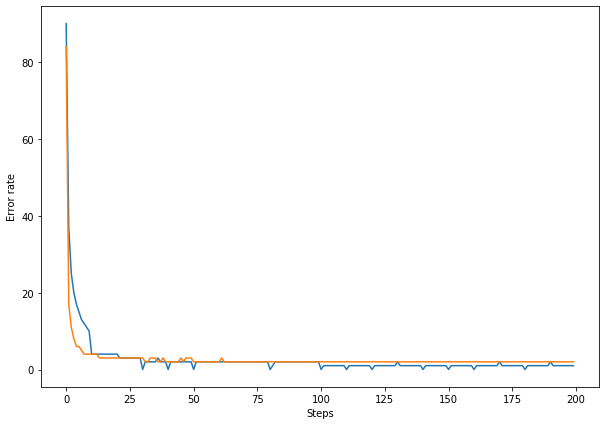

In [54]:
# 绘制训练过程的误差曲线，校验集和测试集上的错误率
plt.figure(figsize=(10,7))
plt.plot(record)
# record 记载了每一个打印周期记录的训练集和校验集上的准确度
plt.xlabel('Steps')
plt.ylabel('Error rate')

标签是： 2


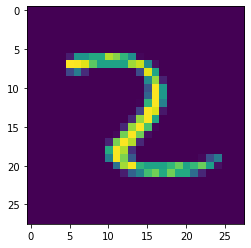

In [75]:
# 随便从测试集中读入一张图片，并检验模型的分类结果，并绘制出来
idx = 2500
muteimg = test_dataset[idx][0].numpy()
plt.imshow(muteimg[0])
print('标签是：',test_dataset[idx][1])

剖析卷积神经网络
------


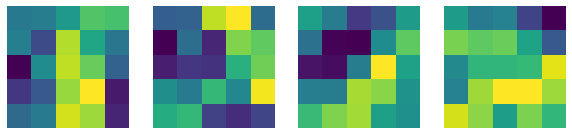

In [76]:
# 提取第一层卷积层的卷积核
plt.figure(figsize=(10,7))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    # 提取第一层卷积核中的权重值，注意conv1是net的属性
    plt.imshow(net.conv1.weight.data.numpy()[i,0,...])

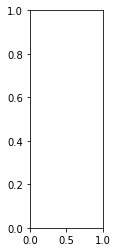

In [77]:
plt.subplot(1,4,2)

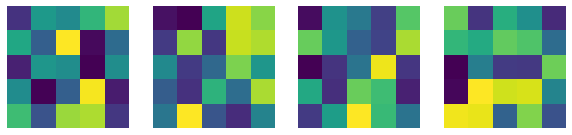

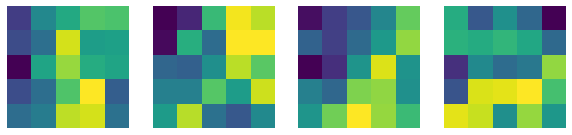

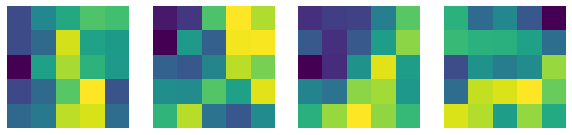

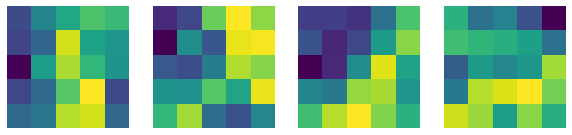

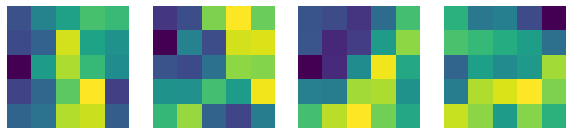

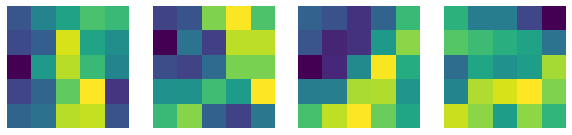

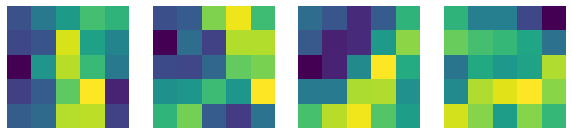

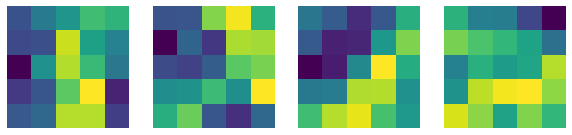

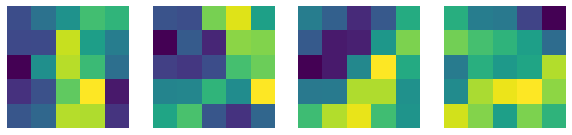

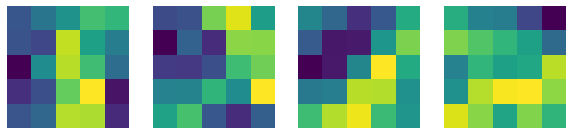

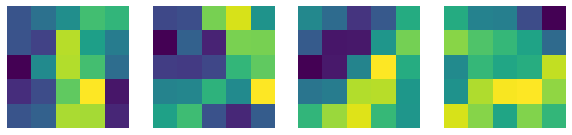

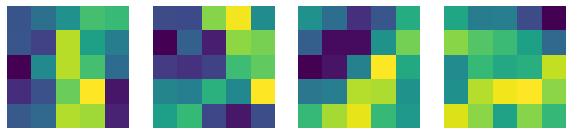

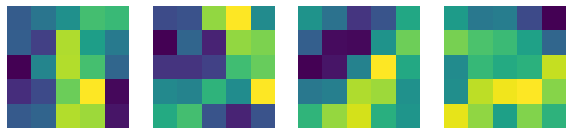

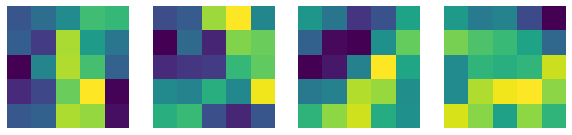

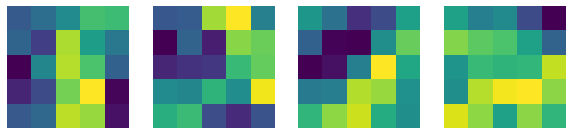

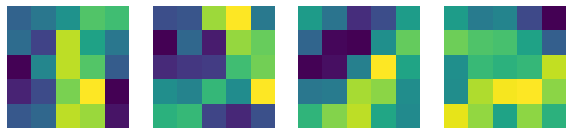

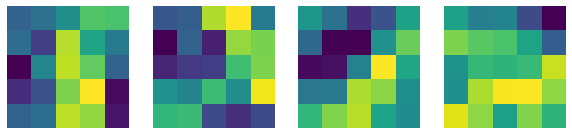

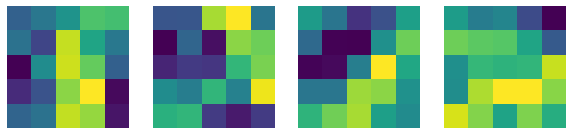

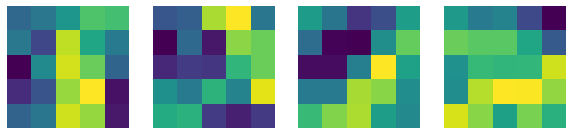

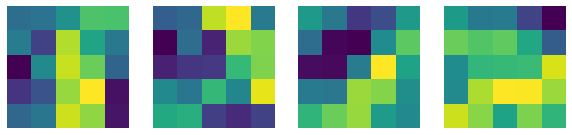

In [78]:
# 将记录在容器中的卷积核权重历史演化数据打印出来
i = 0
for tup in weights:
    if i % 10 == 0 :
        layer1 = tup[0]
        fig = plt.figure(figsize=(10,7))
        for j in range(4):
            plt.subplot(1,4,j+1)
            plt.axis('off')
            plt.imshow(layer1.data.numpy()[j,0,...])
    i += 1

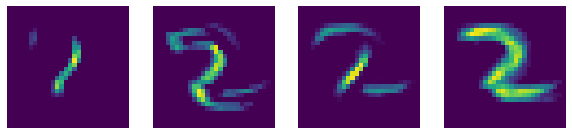

In [79]:
# 调用net的retrieve_features 方法可以抽取出输入当前数据后输出的所有特征图（第一个卷积层和第二个卷积层）
# 首先定义读入的图片，它是从test_dataset 中提取第idx个批次的第0个图
# 其次 unsqueeze 的作用是在最前面添加一维
# 目的是让这个input_x是4维的，这样才能输入给net。补充的那一维度表示batch
input_x = test_dataset[idx][0].unsqueeze(0)
# feature_maps 是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图
feature_maps = net.retrieve_features(input_x)

plt.figure(figsize=(10,7))
# 打印出四个特征图
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0,i,...].data.numpy())

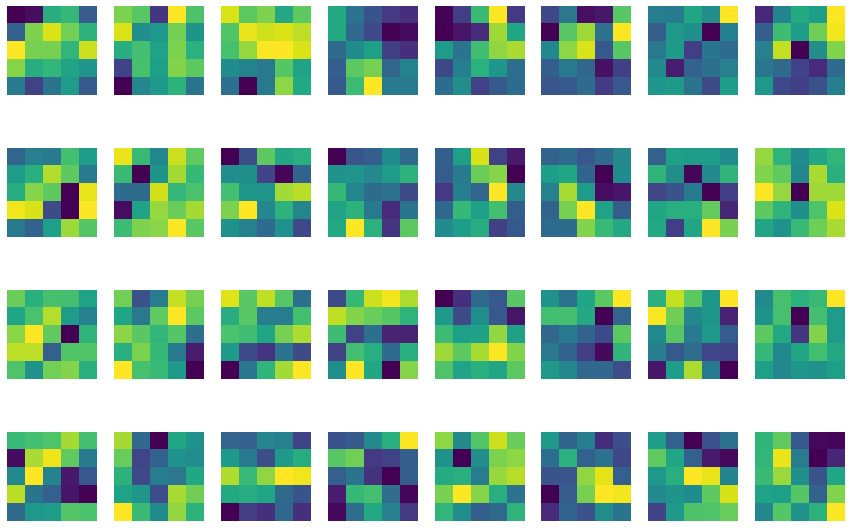

In [80]:
# 绘制第二层的卷积核，每一列对应一个卷积核，一共有8个卷积核
plt.figure(figsize=(15,10))
for i in range(4):
    for j in range(8):
        plt.subplot(4,8,i*8+j+1)
        plt.axis('off')
        plt.imshow(net.conv2.weight.data.numpy()[j,i,...])

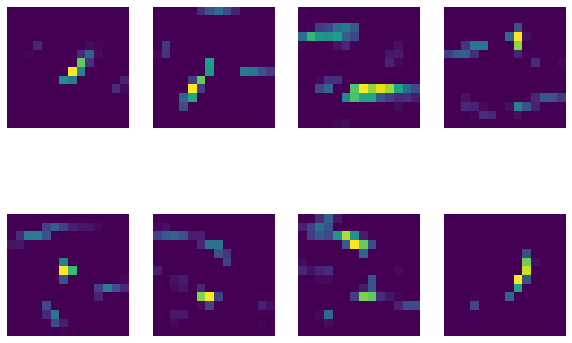

In [81]:
# 绘制第二层的特征图，一共有8个
plt.figure(figsize=(10,7))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0,i,...].data.numpy())

卷积神经网络的鲁棒性试验
-----

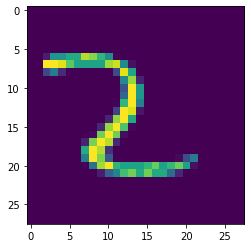

In [82]:
# 提取test_dataset 中第idx个批次第0个图第0个通道对应的图像，定义为a
a = test_dataset[idx][0][0]

# 将平移后的新图像放入b中，根据a给b赋值
# 全0的28X28矩阵
b = torch.zeros(a.size())
# 平移的长度为三个像素
w = 3
# 相对于b中的任意像素i，j，等于a中的i，j+w 位置的像素
for i in range(a.size()[0]):
    for j in range(0,a.size()[1]-w):
        b[i,j] = a[i,j+w]
# 将b画出来
muteimg = b.numpy()
plt.imshow(muteimg)

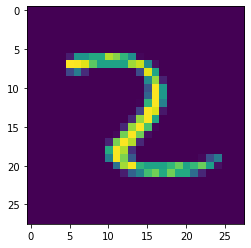

In [83]:
plt.imshow(a)

In [85]:
# 把b喂给神经网络，得到分类结果pred，（prediction是预测的每一个类别的概率的对数值），并把结果打印出来
prediction = net(b.unsqueeze(0).unsqueeze(0))
pred = torch.max(prediction.data,1)[1]
print(pred)

tensor([2])


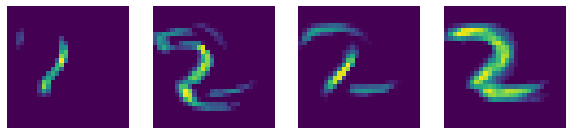

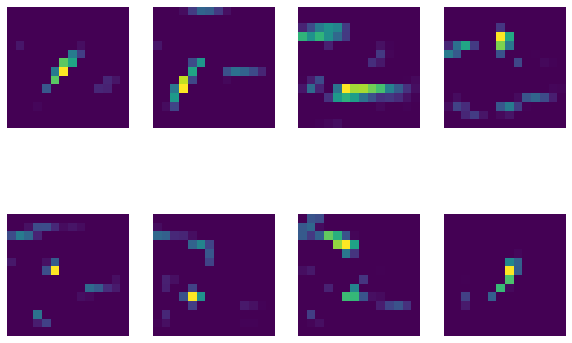

In [88]:
# 提取b对应的featuremap结果
feature_maps = net.retrieve_features(b.unsqueeze(0).unsqueeze(0))
plt.figure(figsize=(10,7))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0,i,...].data.numpy())
    
plt.figure(figsize=(10,7))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0,i,...].data.numpy())

In [106]:
h = test_dataset[6667][0].unsqueeze(0)
print(h.size())
prediction = net(h)
print(prediction)
pred = torch.max(prediction.data,1)[1]
print(pred)
print(test_dataset[6667][1])

torch.Size([1, 1, 28, 28])
tensor([[-2.4078e+01, -3.3928e+01, -3.8978e+01, -3.2105e+01, -3.5093e+01,
         -1.3754e+01, -1.0729e-06, -5.3330e+01, -1.8960e+01, -3.6887e+01]],
       grad_fn=<LogSoftmaxBackward>)
tensor([6])
6
